In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
import pandas as pd
import urllib.request
import nltk
nltk.download('stopwords')
import os
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /home/ssac2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
2767,"Solve farmers' issues, then talk about coaliti...",Shiv Sena chief Uddhav Thackeray took a dig at...
51749,Scientists developing poison-based male contra...,US-based researchers are developing a male con...
40387,Air India finds no buyers as deadline expires ...,The government has not received any bids for A...
31036,Pierre Curie rejected Nobel Prize unless share...,"Born on May 15, 1859, French scientist Pierre ..."
40312,Corruption is on a rise as compared to last go...,Listing the reasons of BJP's loss in Kairana a...
40776,Mum Police uses ball-tampering row meme to spr...,The Mumbai Police on Friday used the reference...
32130,Levitating water drops can improve impurity de...,A US-based study has shown that using sound wa...
58879,Lok Sabha appoints its first woman Secretary G...,Snehlata Shrivastava has been appointed as the...
7750,UP police inspector killed in clashes over ill...,"Subodh Kumar Singh, a Station House Officer (S..."
45136,Goa CM Parrikar to travel to Mumbai for medica...,Goa Chief Minister Manohar Parrikar will trave...


In [5]:
len(data)

98401

# Step 2. 데이터 전처리하기 (추상적 요약)

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [14]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


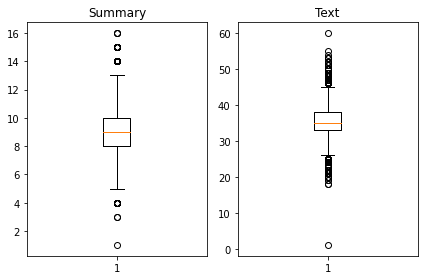

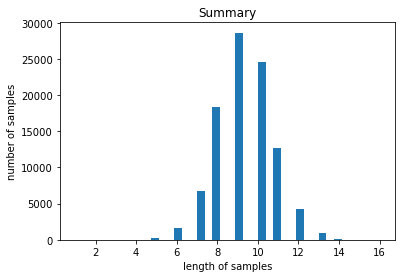

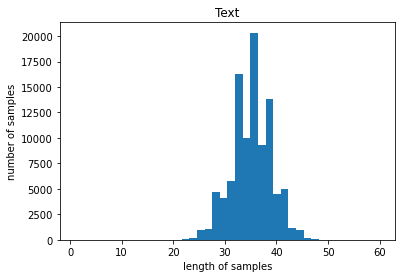

In [19]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 50
summary_max_len = 14

In [21]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98324


In [24]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56475 13039 80296 ...  6276 48556 75833]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19664


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69896
등장 빈도가 5번 이하인 희귀 단어의 수: 45936
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23960
단어 집합에서 희귀 단어의 비율: 65.72049902712601
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1110590999058365


In [32]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[25, 834, 179, 10232, 1090, 7680, 1669, 7680, 11245, 2579, 2741, 17, 9007, 1558, 257, 136, 141, 361, 1558, 10232, 1090, 679, 3754, 6467, 10232, 2349], [107, 22, 567, 466, 1580, 356, 206, 12203, 1089, 1580, 32, 12956, 24, 662, 642, 459, 8558, 694, 8559, 1974, 126, 366, 299, 6189, 99, 1358, 888, 759, 1453, 287, 8], [419, 219, 2495, 8, 567, 384, 910, 3238, 1426, 6801, 14762, 4894, 10698, 3469, 8864, 321, 369, 1307, 508, 14762, 152, 2227, 1249, 921, 4478, 770, 3730, 558, 6802, 88, 1, 63, 377, 140, 13358, 5513, 795, 1482, 7091, 1936, 14762]]


In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30139
등장 빈도가 5번 이하인 희귀 단어의 수: 19716
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10423
단어 집합에서 희귀 단어의 비율: 65.4169016888417
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.654042701875816


In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 39, 1284, 6168, 911, 4675, 82, 5], [1, 269, 467, 350, 2525, 664, 3, 1425, 17], [1, 2346, 3, 1255, 947, 8, 1113, 2031, 1724], [1, 20, 70, 86, 3, 257, 1046, 4851, 4, 151, 3, 2271], [1, 76, 339, 106, 542, 491, 39, 8779, 5878]]
target
decoder  [[39, 1284, 6168, 911, 4675, 82, 5, 2], [269, 467, 350, 2525, 664, 3, 1425, 17, 2], [2346, 3, 1255, 947, 8, 1113, 2031, 1724, 2], [20, 70, 86, 3, 257, 1046, 4851, 4, 151, 3, 2271, 2], [76, 339, 106, 542, 491, 39, 8779, 5878, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


/home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [43]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 143s 463ms/step - loss: 4.8726 - val_loss: 4.4770
Epoch 2/50
308/308 [==============================] - 142s 460ms/step - loss: 4.3415 - val_loss: 4.1697
Epoch 3/50
308/308 [==============================] - 139s 451ms/step - loss: 4.0463 - val_loss: 3.9300
Epoch 4/50
308/308 [==============================] - 135s 439ms/step - loss: 3.8147 - val_loss: 3.7584
Epoch 5/50
308/308 [==============================] - 138s 447ms/step - loss: 3.6331 - val_loss: 3.6357
Epoch 6/50
308/308 [==============================] - 137s 446ms/step - loss: 3.4843 - val_loss: 3.5462
Epoch 7/50
308/308 [==============================] - 139s 452ms/step - loss: 3.3593 - val_loss: 3.4553
Epoch 8/50
308/308 [==============================] - 139s 452ms/step - loss: 3.2519 - val_loss: 3.3843
Epoch 9/50
308/308 [==============================] - 144s 469ms/step - loss: 3.1570 - val_loss: 3.3395
Epoch 10/50
308/308 [==============================] - 139s 450m

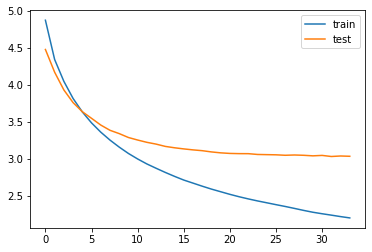

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [51]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [52]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : beijing court sentenced chairman group behind china biggest online ponzi scheme life prison also fined million fundraising fraud smuggling precious metals owning guns illegally authorities alleged platform defrauded lakh people billion 
실제 요약 : man behind china biggest scheme gets life sentence 
예측 요약 :  china gets mn in prison for years


원문 : uk pm theresa may signed confidence supply deal northern irish democratic party allowing officially form minority government deal came two weeks talks worth billion reportedly deliver benefits northern ireland terms jobs investment health education 
실제 요약 : uk pm theresa may signs deal to form minority government 
예측 요약 :  uk pm theresa may become government to set up to


원문 : congress leader navjot singh sidhu saturday said bjp puppet rich key turn make bend questioned bjp equation gautam adani said loan lakh crore debt chhattisgarh farmers crore 
실제 요약 : bjp is puppet for wealthy and influential people sidhu 
예측 요약 :  bjp is not sidhu on

예측 요약 :  mumbai students to get married in jee


원문 : passengers onboard thiruvananthapuram bengaluru indigo flight saturday panicked cabin crew detected smell smoke minor laptop placed handbag airline said passengers relocated adjacent seats smoke discharged fire extinguisher injuries reported incident plane landed safely bengaluru 
실제 요약 : spark smoke from laptop bag cause alert on indigo flight 
예측 요약 :  flight diverted after passengers grounded for cockpit


원문 : united states president donald trump mistaken french island mediterranean sea part italy part italy since th century ruled republic genoa trolled trump tweeting thank giving us back make italian 
실제 요약 : trump mistakes france for italy 
예측 요약 :  trump winter olympics ceremony


원문 : website islamic state official news agency hacked collective muslim activists known di according reports also reportedly leaked email addresses around subscribers hack occurred isis claimed increased security recently become target numerous cyb

예측 요약 :  russia to pay russian ships to ukraine


원문 : uttarakhand high court said would act legal guardian cows state directions state government court ordered setting cow shelter every cluster villages registering cases abandon cattle court order added commercial charges shall levied supplying electricity 
실제 요약 : uttarakhand hc appoints itself legal guardian of cows in state 
예측 요약 :  hc orders hc order to cow cow shelter cases


원문 : european union leaders saturday promised embrace british province northern ireland brexit ever ireland notably good friday agreement end violence northern ireland holding sides border island uk ireland see public support 
실제 요약 : united ireland would be full member eu 
예측 요약 :  eu to europe first ever state of brexit


원문 : film lipstick burkha declared eligible compete th golden globe awards film selected hollywood foreign press association screening indian film festival los angeles director film alankrita shrivastava choose submit film nomination upc

# Step 5. Summa를 이용해서 추출적 요약해보기

In [53]:
import requests
from summa.summarizer import summarize

- summarize 사용 예시

print(summarize(text, ratio=0.005, split=True))    
print(summarize(text, words=50))

In [54]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(len(text), type(text))
print(text)

35932 <class 'str'>
The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down

- 학습된 모델 결과를 바탕으로 추상적 요약과 추출적 요약 문장을 비교해보기

In [138]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    
    dot_index = 0
    new_text = []
    for j in seq2text(encoder_input_test[i]).split():
        new_text.append(j)
        dot_index += 1
        if dot_index %5 == 4:
            new_text.append(".")
        
    print("추출적 요약 :", summarize(' '.join(new_text), ratio=0.3))
    print("\n")

원문 : beijing court sentenced chairman group behind china biggest online ponzi scheme life prison also fined million fundraising fraud smuggling precious metals owning guns illegally authorities alleged platform defrauded lakh people billion 
실제 요약 : man behind china biggest scheme gets life sentence 
추상적 요약 :  china gets mn in prison for years
추출적 요약 : beijing court sentenced chairman .
people billion


원문 : uk pm theresa may signed confidence supply deal northern irish democratic party allowing officially form minority government deal came two weeks talks worth billion reportedly deliver benefits northern ireland terms jobs investment health education 
실제 요약 : uk pm theresa may signs deal to form minority government 
추상적 요약 :  uk pm theresa may become government to set up to
추출적 요약 : signed confidence supply deal northern .
form minority government deal came .


원문 : congress leader navjot singh sidhu saturday said bjp puppet rich key turn make bend questioned bjp equation gautam adan

추상적 요약 :  jacqueline shares old pic with sridevi sridevi death
추출적 요약 : jacqueline fernandez paid tribute .


원문 : italian sergio famed plans perform first human head transplant claimed severed spinal mice nine mice special able move days six mice treated recover however mice died within month 
실제 요약 : surgeon cuts successfully rejoins of mice 
추상적 요약 :  italian man who lost to brain with brain
추출적 요약 : six mice treated recover however .


원문 : device called breath developed mines cryptocurrency via human measures much air inhaled lungs data sent small computer mining monero blockchain user breath determines computer rate determines much monero computer mine 
실제 요약 : device cryptocurrencies based on breath rate 
추상적 요약 :  device that lost in ad made in ad made
추출적 요약 : rate determines much monero computer .


원문 : following pm narendra modi call conserve oil fuel outlets seven states union territory puducherry shut every sunday starting may petroleum dealers consortium said would affec

추상적 요약 :  andhra pradesh to get special status for andhra pradesh
추출적 요약 : state reportedly recorded lightning entire .
since tuesday due lightning


원문 : sitting mla rao andhra pradesh visakhapatnam former mla constituency shot dead naxals sunday leaders telugu desam party gone valley supporters extremists said involved attack 
실제 요약 : mla former mla shot dead by naxals in andhra pradesh 
추상적 요약 :  mla who killed mla for beating naxals in andhra
추출적 요약 : sitting mla rao andhra .


원문 : brazil deployed troops rio de janeiro combat rising crime city average three people killed stray bullets day year troops preparing operations criminal organisations involved drug trafficking theft crimes defence minister said 
실제 요약 : troops deployed in brazil rio to fight crime surge 
추상적 요약 :  brazil to fight in republic of republic day
추출적 요약 : brazil deployed troops rio .
stray bullets day year troops .


원문 : french woman stranded known killer mountain pakistan occupied kashmir rescued however said

In [57]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
origin = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [139]:
for i in range(50, 100):
    print("원문 :", origin['text'][i])
    print("원문의 길이 :", len(origin['text'][i]))
    print("실제 요약 :", origin['headlines'][i])
    print("추출적 요약 :", summarize(origin['text'][i], ratio=0.37)) # clean_text[i]
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
원문의 길이 : 395
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
추출적 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the se

### 추상적 요약 vs. 추출적 요약

- 우선 추출적 요약을 하는 과정에서 전처리가 진행된 데이터를 통해 수행하였을 때 완성된 문장으로 요약되지 않는 문제점이 발생하였습니다. 따라서 전처리가 되지 않은 original 데이터를 가지고 수행한 추출적 요약 문장과 추상적 요약 문장을 비교해 두 방법의 성능(?)에 대해 이야기해보려 합니다.

우선 추출적 요약의 경우 인코딩과 전처리가 전혀 이루어지지 않은 그대로의 문장에서 적용이 되는 것을 확인했습니다. 전체 문장의 길이를 고려해 ratio를 0.37정도로 주어 너무 짧은 문장이 아니면 요약할 수 있도록 설정하였습니다.

추상적 요약의 경우 대부분 하나의 완성된 문장으로 보였으며, 의미 또한 어느 정도 유사한 의미를 가지는 경우가 있었습니다.
반면에 추출적 요약 문장을 읽어보았을 때, 완성된 하나의 문장으로 보기 어려운 경우가 많았고, 요악된 내용의 의미 또한 실제 요약 내용과는 다소 거리가 있는 내용으로 확인됩니다.

------------------------------------------------------------------------------------
원문 : turkish government denied role publication classified information us military bases syria state news agency list us syria included information troop numbers equipment operational procedures responding report us expressed concerns sensitive information would forces <br>
<b>실제 요약 : turkish government denies role in classified us info leak <br></b>
<span style="color:blue"><b>추상적 요약 :  turkey to shut down on syria military leaks report </b><br></span>
<span style="color:red"><b> 추출적 요약 : list us syria included information. sensitive information would forces </b></span>
------------------------------------------------------------------------------------

원문 : film lipstick burkha declared eligible compete th golden globe awards film selected hollywood foreign press association screening indian film festival los angeles director film alankrita shrivastava choose submit film nomination upcoming golden <br>
<b> 실제 요약 : lipstick under my burkha eligible to compete at golden globe <br>
<span style="color:blue"> 추상적 요약 :  lipstick under the burkha at world film festival <br>
<span style="color:red">추출적 요약 : film lipstick burkha declared . festival los angeles director film . </b></span>
-----------------------------------------------------------------------------------
    
원문 : video surfaced online wherein indian air force officer seen thrashed mob southeast delhi sangam vihar area reportedly incident took place april officer motorcycle touched car accused following attacked robbed delhi police arrested three persons connection <br>
<b>실제 요약 : video shows iaf officer being thrashed by mob three held <br>
<span style="color:blue">추상적 요약 :  video of iaf officer assaulted by men in delhi <br>
<span style="color:red">추출적 요약 : indian air force officer seen. place april officer motorcycle touched. </b></span>

# 회고

## * 이번 프로젝트에서 어려웠던 점.
    진행과정에서는 특별히 어려운 점은 없었지만, 추상적요약과 추출적요약 결과 모두 만족스럽지 못한것 같습니다. 추출적 요약을 하는 과정에서 전처리를 수행한 문장에 대해서 Summa가 제대로 동작하지 않는 것 같았습니다. 또한, 기존 original 데이터를 가지고 수행했을 때, 같은 문장에 대한 결과값을 찾는 과정이 쉽지 않았습니다.
    
    
## * 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
    예전에도 한번 고민했던 부분이긴 한데 자연어 데이터의 경우 연속성이 있어서 패딩을 하는 과정에 있어 앞부분에 0으로 채우는 Pre 방식을 선택할 지, 뒤쪽을 0으로 채우는 Post방식을 선택할지에 대해 결정해야합니다. 이전 노드때도 Pre 방식보다 Post 방식이 성능이 더 좋았었는데, 이번 노드 역시 Post방식에서 성능이 아주 약간 더 좋았던 것 같습니다.
    개인적으로는 Pre padding을 적용했을 때 더 성능이 좋아야 한다고 생각이 들었지만, Post padding 방식이 성능이 더 좋은 것을 보고 의아했습니다.
    
    
## * 루브릭 평가 지표를 맞추기 위해 시도한 것들.

1) Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었는가?
    
    Yes. 각 단계를 빠짐없이 순차적으로 진행하였습니다.
    

2) 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었는가?

    Yes. 모델 학습 과정에서 오류가 없었으며, 학습 결과를 그래프로 출력한 결과 안정적으로 수렴하는 것을 확인하였습니다. 또한, 실제 요약문과 유사한 요약 문장 결과를 얻었습니다.

3) Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해보았다. 두 요약 결과를 문법 완성도 측면과 핵심 단어 포함 측면으로 나누어 비교분석 결과를 제시하였는가?
    
    Yes. Summa를 이용해서 추출적 요약을 시도해보았고, 추상적 요약 결과와 비교하여 비교 분석 & 결과를 제시해보았습니다.